In [29]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

In [2]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [3]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [5]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [7]:
dataset=ImageFolder(data_dir+'/train',transform=ToTensor())

In [8]:
img,label=dataset[0]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [9]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
def show_example(img,label):
    print('Label: ',dataset.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  airplane (0)


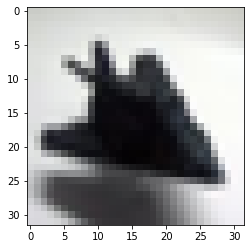

In [16]:
show_example(*dataset[0])

Label:  airplane (0)


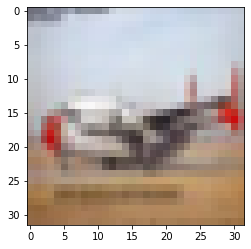

In [17]:
show_example(*dataset[1099])

In [19]:
def split_indices(n,val_pct=0.1,seed=99):
    n_val=int(val_pct*n)
    np.random.seed(seed)
    idxs=np.random.permutation(n)
    return idxs[n_val:],idxs[:n_val]

In [20]:
val_pct=0.2
rand_seed=42
train_indices,val_indices=split_indices(len(dataset),val_pct,rand_seed)
print(len(train_indices),len(val_indices))
print('Sample validation indices: ',val_indices[:10])

40000 10000
Sample validation indices:  [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [24]:
batch_size=100
train_sampler=SubsetRandomSampler(train_indices)
train_dl=DataLoader(dataset,batch_size,sampler=train_sampler)
val_sampler=SubsetRandomSampler(val_indices)
val_dl=DataLoader(dataset,batch_size,sampler=val_sampler)

In [26]:
def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(10,10))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images,10).permute(1,2,0))

In [ ]:
show_batch(train_dl)

In [30]:
simple_model=nn.Sequential(nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1),nn.MaxPool2d(2,2))

In [32]:
for images,labels in train_dl:
    print('images.shape: ',images.shape)
    out=simple_model(images)
    print('out.shape: ',out.shape)
    break

images.shape:  torch.Size([100, 3, 32, 32])
out.shape:  torch.Size([100, 8, 16, 16])


In [33]:
model=nn.Sequential(nn.Conv2d(3,16,kernel_size=3,stride=1,padding=1),nn.ReLU(),nn.MaxPool2d(2,2),
                    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),nn.ReLU(),nn.MaxPool2d(2,2),
                    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),nn.ReLU(),nn.MaxPool2d(2,2),
                    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),nn.ReLU(),nn.MaxPool2d(2,2),
                    nn.Conv2d(16,16,kernel_size=3,stride=1,padding=1),nn.ReLU(),nn.MaxPool2d(2,2),
                    nn.Flatten(),
                    nn.Linear(16,10)
                    )

In [34]:
model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=16, out_features=10, bias=True)
)

In [35]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return[to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [36]:
device=get_default_device()
device

device(type='cuda')

In [37]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(val_dl,device)
to_device(model,device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=16, out_features=10, bias=True)
)

In [38]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):
    preds=model(xb)
    loss=loss_func(preds,yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    metric_result=None
    if metric is not None:
        metric_result=metric(preds,yb)

    return loss.item(),len(xb),metric_result